# Identification diagnostics

We compute Hessian, Jacobian, and interpret ranks.


Ranks: {'rank_hessian': 64, 'rank_hessian_h': 22, 'rank_Dc_hp': 64, 'rank_J': 96}
Condition numbers: {'cond_H': '1.02e+16', 'cond_H_h': '1.11e+06', 'cond_Dc': '1.09e+16', 'cond_J': '1.06e+06'}


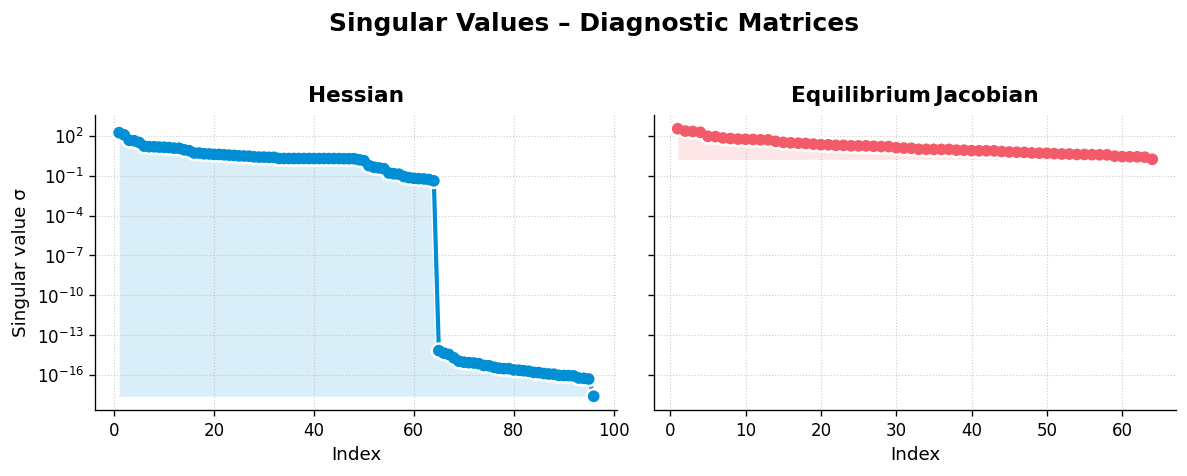

In [1]:
# %%
# 02_identification_test.py
#
# Compute Hessian, Jacobian, and rank/condition diagnostics for the
# same game and interpret the results.

# Author: Mirko De Maria (July 2025)
# m.de-maria@imperial.ac.uk
# mirkodemaria.com
"""
# 02 Identification Diagnostics

Here we:

* Re-use the entry-game parameters  
* Build the log-likelihood Hessian and the equilibrium-constraint Jacobian  
* Check matrix ranks and condition numbers  
* Visualise singular values of H and Dc
"""
# %%
import sys, pathlib, os
# Path to the *src* directory that contains some packages
root = pathlib.Path().resolve()          
src_path = root.parent / "src"        
sys.path.append(str(src_path))
import numpy as np
import matplotlib.pyplot as plt
from discrete_game_identification import (
    solve_equilibrium,
    compute_joint_distribution,
    compute_scores_general,
    build_hessian_general,
    build_Dc_hp_general,
    ranks_and_condition_numbers,
)

plt.rcParams["figure.figsize"] = (6, 4)

# %% 1  Re‑create the game (same as notebook 01)
nplayers, num_z, num_kappa = 2, 4, 2
zvals = np.arange(num_z)/(num_z-1)
alpha = np.zeros((nplayers, num_z, num_kappa))
beta  = np.zeros((nplayers, nplayers, num_z, num_kappa))
alpha[0] = -2 + 5*zvals[:,None] + 1*np.arange(num_kappa)
beta[0,1] = -2
alpha[1] = -3 + 4*zvals[:,None] + 0.5*np.arange(num_kappa)
beta[1,0] = -3

p_equil = solve_equilibrium(alpha, beta)
num_states = num_z**nplayers
h = np.full((num_states, num_kappa), (0.7, 0.3))

# %% 2  Build likelihood pieces
Q, actions = compute_joint_distribution(p_equil, h)
scores     = compute_scores_general(p_equil, h, actions)
H          = build_hessian_general(scores, Q)
Dc         = build_Dc_hp_general(p_equil, beta)

ranks, conds = ranks_and_condition_numbers(H, Dc)
print("Ranks:", ranks)
print("Condition numbers:", {k:f"{v:.2e}" for k,v in conds.items()})

import matplotlib.patheffects as pe

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# --- Cosmetics -------------------------------------------------------
palette = ["#008FD5", "#F45B69"]  
lw       = 2.5
mksize   = 6
halo     = [pe.Stroke(linewidth=lw + 1.5, foreground="white"), pe.Normal()]

matrices = [(H, "Hessian",          palette[0]),
            (Dc, "Equilibrium Jacobian", palette[1])]

for ax, (M, title, color) in zip(axes, matrices):
    svals = np.linalg.svd(M, compute_uv=False)
    idx   = np.arange(1, len(svals) + 1)

    # main curve
    ax.semilogy(idx, svals,
                marker="o", markersize=mksize, linewidth=lw,
                color=color, path_effects=halo)
    ax.fill_between(idx, svals[-1], svals, color=color, alpha=0.15, linewidth=0)

    # cosmetics
    ax.set_title(title, fontsize=13, weight="bold", pad=8)
    ax.set_xlabel("Index", fontsize=11)
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Singular value σ", fontsize=11)

fig.suptitle("Singular Values – Diagnostic Matrices", fontsize=15, weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
